# 3+ Component Mixture models and mixture weights stochastic sampling

As of the writing of this tutorial mixture models within `GammaBayes` are implemented using Dirichlet priors on the weights for each mixture, specifially the [stick-breaking process](https://en.wikipedia.org/wiki/Dirichlet_process#The_stick-breaking_process). The overall process for a user should not be that different to the two component case but we thought it would make it more clear if an example was given.

And just a heads up, to show the utility of this set up we need enough event numbers to see something nice, so this script could take 20+ mins to run depending on your system.

## Imports and general setup

In [1]:
import os, sys, time
from tqdm import tqdm

# from gammabayes.BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from gammabayes.likelihoods.irfs import log_edisp, log_psf, single_loglikelihood, log_psf_normalisations, log_edisp_normalisations, log_aeff
from gammabayes.utils.plotting import logdensity_matrix_plot
from gammabayes.utils.event_axes import energy_true_axis, longitudeaxistrue, latitudeaxistrue, energy_recon_axis, longitudeaxis, latitudeaxis, makelogjacob


from gammabayes.utils import logspace_simpson, convertlonlat_to_offset, iterate_logspace_simps
from gammabayes.samplers import discrete_hyperparameter_continuous_mix_post_process_sampler

# from gammabayes.utils.utils import inverse_transform_sampling
from gammabayes.hyper_inference import discrete_hyperparameter_likelihood
from gammabayes.priors import discrete_logprior, log_bkg_CCR_dist
from gammabayes.likelihoods.likelihood import discrete_loglikelihood
from gammabayes.dark_matter import SS_DM_dist
from gammabayes.priors.astro_sources import construct_hess_source_map, construct_fermi_gaggero_matrix, construct_hess_source_map_interpolation, construct_log_fermi_gaggero_bkg
from gammabayes.utils.utils import bin_centres_to_edges

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import interpolate, special, integrate, stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

import functools, random
from multiprocessing import Pool, freeze_support
import multiprocessing
import pandas as pd
random.seed(0)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Event Simulations

We first do some simulations specifically for this script so that we explicitly show that we recover the mixture fractions that we initially set. In this script we show that you can explicitly set the parameters within the script itself and do not require a configuration file, but again we recommend you do so.

In [2]:
NumEvents                   = 500
sigfraction                 = 0.5
ccr_of_bkg_fraction         = 0.8
diffuse_of_astro_fraction   = 0.4
nsig                        = int(round(sigfraction*NumEvents))
nastrodiffuse               = int(round((1-sigfraction)*(1-ccr_of_bkg_fraction)*diffuse_of_astro_fraction*NumEvents))
nastropoint                 =int(round((1-sigfraction)*(1-ccr_of_bkg_fraction)*(1-diffuse_of_astro_fraction)*NumEvents))
nccr                        = int(round((1-sigfraction)*ccr_of_bkg_fraction*NumEvents))
print(nsig, nccr, nastrodiffuse, nastropoint,)
if nccr+nastrodiffuse+nastropoint+nsig!=NumEvents:
    print(1/0)
numcores                    = 8
truemass                    = 3.0


startertimer = time.perf_counter()
true_logjacob = np.meshgrid(makelogjacob(energy_true_axis),longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]


250 200 20 30


### Astro Background setup

In [3]:
diffuse_astro_bkg_prior = discrete_logprior(logfunction=construct_log_fermi_gaggero_bkg(log_aeff=log_aeff), name='Diffuse Astrophysical Background Prior',
                               axes=(energy_true_axis, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=true_logjacob)


In [4]:
point_astro_bkg_prior = discrete_logprior(logfunction=construct_hess_source_map_interpolation(), name='Point Source Astrophysical Background Prior',
                               axes=(energy_true_axis, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=true_logjacob)


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


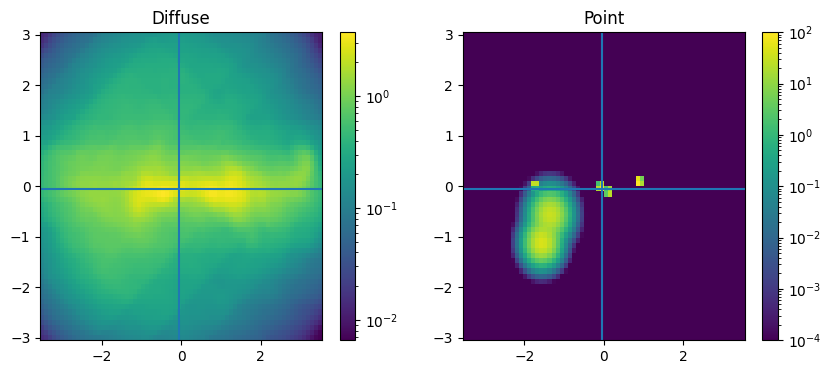

In [5]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Diffuse')
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp(special.logsumexp(
    construct_log_fermi_gaggero_bkg(normalise=True)(*np.meshgrid(energy_true_axis, longitudeaxistrue, latitudeaxistrue, indexing='ij'))+true_logjacob, axis=0)).T,
               norm=LogNorm())

lonmesh, latmesh = np.meshgrid(longitudeaxistrue, latitudeaxistrue, indexing='ij')
zeroindex = convertlonlat_to_offset(np.array([lonmesh.flatten(), latmesh.flatten()])).argmin()
zeroindex_coord = np.unravel_index(zeroindex, shape=lonmesh.shape)
plt.axvline(longitudeaxistrue[zeroindex_coord[0]])
plt.axhline(latitudeaxistrue[zeroindex_coord[1]])
plt.colorbar()

plt.subplot(122)
plt.title('Point')
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp(special.logsumexp(construct_hess_source_map_interpolation()(
    *np.meshgrid(energy_true_axis, longitudeaxistrue, latitudeaxistrue, indexing='ij'))+true_logjacob, axis=0)).T,
               norm=LogNorm(vmin=1e-4, vmax=1e2))
lonmesh, latmesh = np.meshgrid(longitudeaxistrue, latitudeaxistrue, indexing='ij')
zeroindex = convertlonlat_to_offset(np.array([lonmesh.flatten(), latmesh.flatten()])).argmin()
zeroindex_coord = np.unravel_index(zeroindex, shape=lonmesh.shape)
plt.axvline(longitudeaxistrue[zeroindex_coord[0]])
plt.axhline(latitudeaxistrue[zeroindex_coord[1]])
plt.colorbar()

### Mis-identified Background Setup

In [6]:
ccr_bkg_prior = discrete_logprior(logfunction=log_bkg_CCR_dist, name='CCR Mis-identification Background Prior',
                               axes=(energy_true_axis, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=true_logjacob)

### Signal Setup

In [7]:
SS_DM_dist_instance= SS_DM_dist(longitudeaxistrue, latitudeaxistrue, density_profile='nfw')
logDMpriorfunc = SS_DM_dist_instance.func_setup()

In [8]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(energy_true_axis, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(truemass,), hyperparameter_names=['mass'], logjacob=true_logjacob)
DM_prior

discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x158023ba0>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

## True Value Simulation

In [9]:
sig_energy_vals,siglonvals,siglatvals                                   = DM_prior.sample(nsig)
ccr_energy_vals,ccrlonvals,ccrlatvals                                   = ccr_bkg_prior.sample(nccr)
diffuse_astro_energy_vals,diffuse_astrolonvals,diffuse_astrolatvals     = diffuse_astro_bkg_prior.sample(nastrodiffuse)
point_astro_energy_vals,point_astrolonvals,point_astrolatvals           = point_astro_bkg_prior.sample(nastropoint)

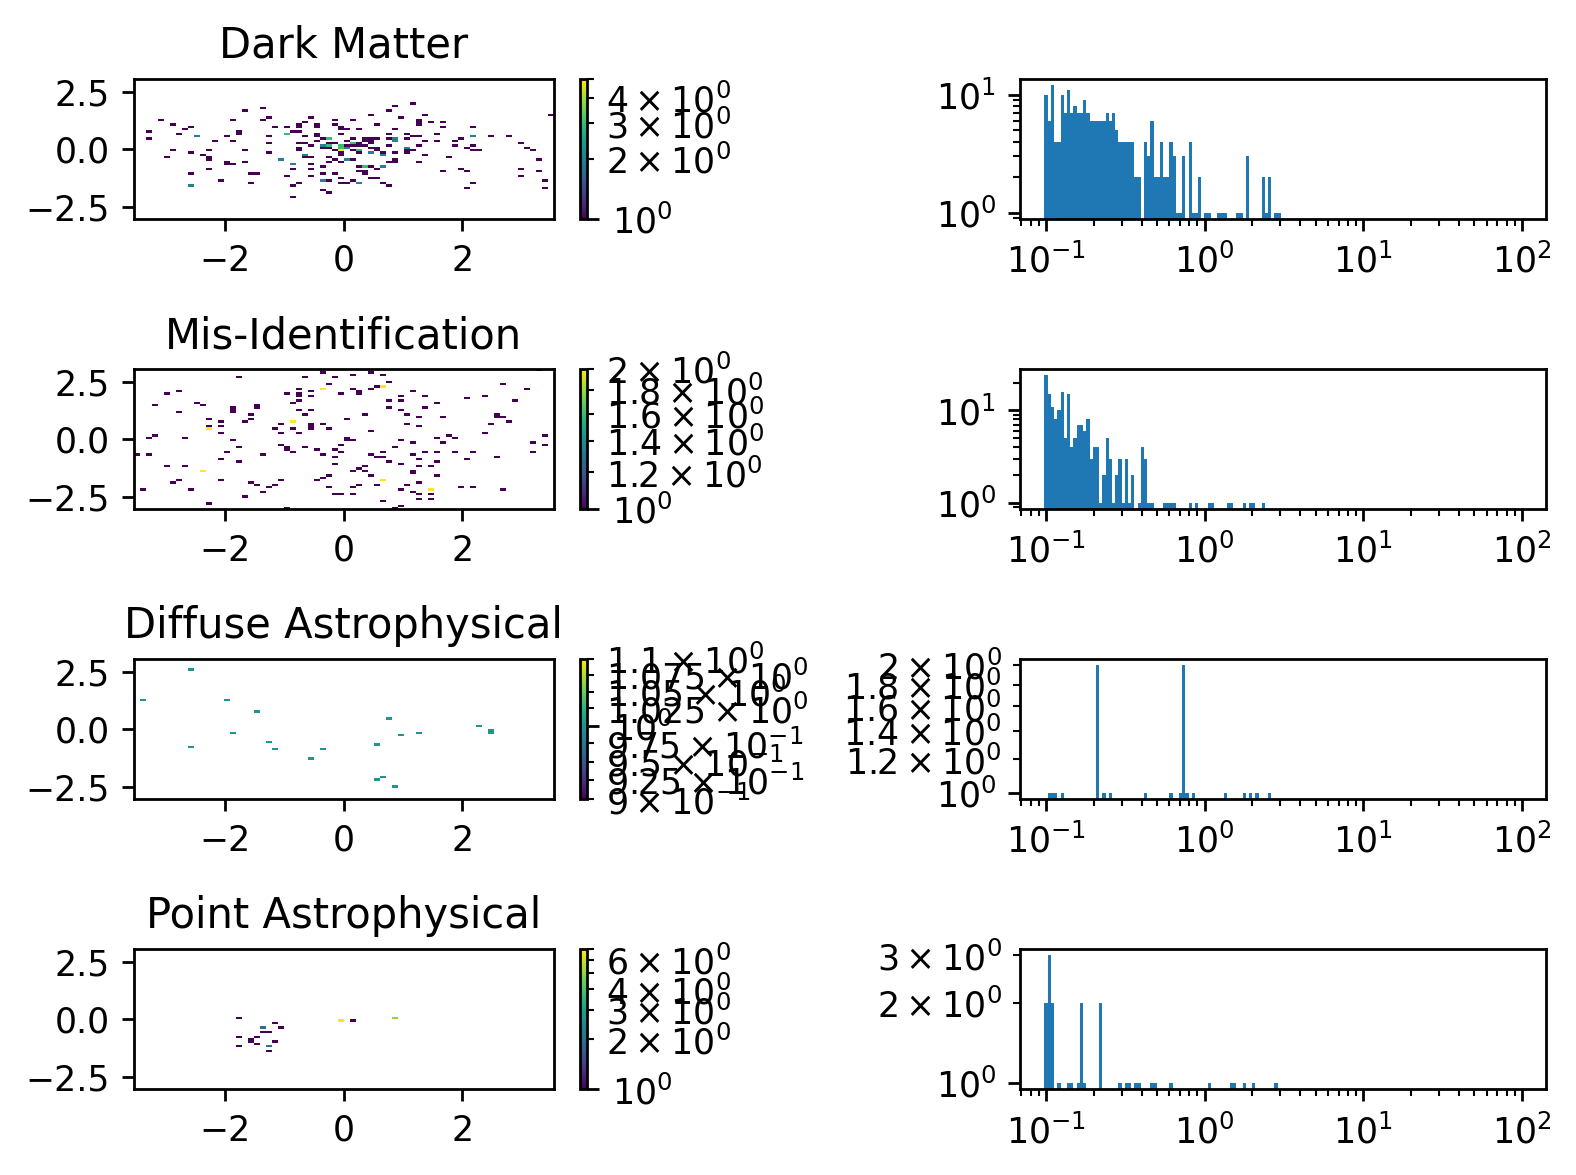

In [10]:
plt.figure(dpi=250)
plt.subplot(421)
plt.title("Dark Matter")
plt.hist2d(siglonvals,siglatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)), norm=LogNorm())
plt.colorbar()

plt.subplot(422)
plt.hist(sig_energy_vals, bins=bin_centres_to_edges(energy_true_axis))
plt.loglog()

plt.subplot(423)
plt.title("Mis-Identification")

plt.hist2d(ccrlonvals,ccrlatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)), norm=LogNorm())
plt.colorbar()


plt.subplot(424)
plt.hist(ccr_energy_vals, bins=bin_centres_to_edges(energy_true_axis))
plt.loglog()

plt.subplot(425)
plt.title("Diffuse Astrophysical")
plt.hist2d(diffuse_astrolonvals,diffuse_astrolatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)), norm=LogNorm())
plt.colorbar()

plt.subplot(426)
plt.hist(diffuse_astro_energy_vals, bins=bin_centres_to_edges(energy_true_axis))
plt.loglog()

plt.subplot(427)
plt.title("Point Astrophysical")
plt.hist2d(point_astrolonvals,point_astrolatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)), norm=LogNorm())
plt.colorbar()

plt.subplot(428)
plt.hist(point_astro_energy_vals, bins=bin_centres_to_edges(energy_true_axis))
plt.loglog()



plt.tight_layout()
plt.show()

## Reconstructed Value Simulation

In [11]:
logjacob = np.meshgrid(energy_recon_axis, longitudeaxis, latitudeaxis, indexing='ij')[0]

In [12]:
logjacob = np.log(energy_recon_axis)
edisp_like = discrete_loglikelihood(logfunction=log_edisp, 
                                    axes=(energy_recon_axis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(energy_true_axis, longitudeaxistrue, latitudeaxistrue,), logjacob=logjacob,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])

Number of input dimensions 1


In [13]:
psf_like = discrete_loglikelihood(logfunction=log_psf, 
                                    axes=(longitudeaxis, latitudeaxis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(energy_true_axis, longitudeaxistrue, latitudeaxistrue,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2


discrete log likelihood class
---------------------------------
name = point spread function 
logfunction type is <function log_psf at 0x153fdcfe0>
input units of None
over axes ['longitude recon', 'latitude recon']
with dependent axes ['log10E true', 'lon', 'lat']

### Signal

In [14]:
signal_energy_measured = [np.squeeze(edisp_like.sample((energy_val,*coord,), numsamples=1)) for energy_val,coord  in notebook_tqdm(zip(sig_energy_vals, np.array([siglonvals, siglatvals]).T), total=nsig)]
sig_lonlat_psf_samples =  [psf_like.sample((energy_val,*coord,), 1).tolist() for energy_val,coord  in notebook_tqdm(zip(sig_energy_vals, np.array([siglonvals, siglatvals]).T), total=nsig)]

signal_lon_measured = [sig_lonlat_psf_sample[0] for sig_lonlat_psf_sample in sig_lonlat_psf_samples]
signal_lat_measured = [sig_lonlat_psf_sample[1] for sig_lonlat_psf_sample in sig_lonlat_psf_samples]

100%|██████████| 250/250 [00:02<00:00, 116.99it/s]


### Background

In [15]:
diffuse_astro_energy_measured = [np.squeeze(edisp_like.sample((energy_val,*coord,), numsamples=1)) for energy_val,coord  in notebook_tqdm(zip(diffuse_astro_energy_vals, np.array([diffuse_astrolonvals, diffuse_astrolatvals]).T), total=nastrodiffuse)]
diffuse_astro_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(diffuse_astro_energy_vals, np.array([diffuse_astrolonvals, diffuse_astrolatvals]).T), total=nastrodiffuse)]

diffuse_astro_lon_measured = [diffuse_astro_lonlat_psf_sample[0] for diffuse_astro_lonlat_psf_sample in diffuse_astro_lonlat_psf_samples]
diffuse_astro_lat_measured = [diffuse_astro_lonlat_psf_sample[1] for diffuse_astro_lonlat_psf_sample in diffuse_astro_lonlat_psf_samples]


100%|██████████| 20/20 [00:00<00:00, 114.19it/s]


In [16]:
point_astro_energy_measured = [np.squeeze(edisp_like.sample((energy_val,*coord,), numsamples=1)) for energy_val,coord  in notebook_tqdm(zip(point_astro_energy_vals, np.array([point_astrolonvals, point_astrolatvals]).T), total=nastropoint)]
point_astro_lonlat_psf_samples =  [psf_like.sample((energy_val,*coord,), 1).tolist() for energy_val,coord  in notebook_tqdm(zip(point_astro_energy_vals, np.array([point_astrolonvals, point_astrolatvals]).T), total=nastropoint)]

point_astro_lon_measured = [point_astro_lonlat_psf_sample[0] for point_astro_lonlat_psf_sample in point_astro_lonlat_psf_samples]
point_astro_lat_measured = [point_astro_lonlat_psf_sample[1] for point_astro_lonlat_psf_sample in point_astro_lonlat_psf_samples]

100%|██████████| 30/30 [00:00<00:00, 110.45it/s]


In [17]:
ccr_energy_measured = [np.squeeze(edisp_like.sample((energy_val,*coord,), numsamples=1)) for energy_val,coord  in notebook_tqdm(zip(ccr_energy_vals, np.array([ccrlonvals, ccrlatvals]).T), total=nccr)]
ccr_lonlat_psf_samples =  [psf_like.sample((energy_val,*coord,), 1).tolist() for energy_val,coord  in notebook_tqdm(zip(ccr_energy_vals, np.array([ccrlonvals, ccrlatvals]).T), total=nccr)]

ccr_lon_measured = [ccr_lonlat_psf_sample[0] for ccr_lonlat_psf_sample in ccr_lonlat_psf_samples]
ccr_lat_measured = [ccr_lonlat_psf_sample[1] for ccr_lonlat_psf_sample in ccr_lonlat_psf_samples]

100%|██████████| 200/200 [00:01<00:00, 119.40it/s]


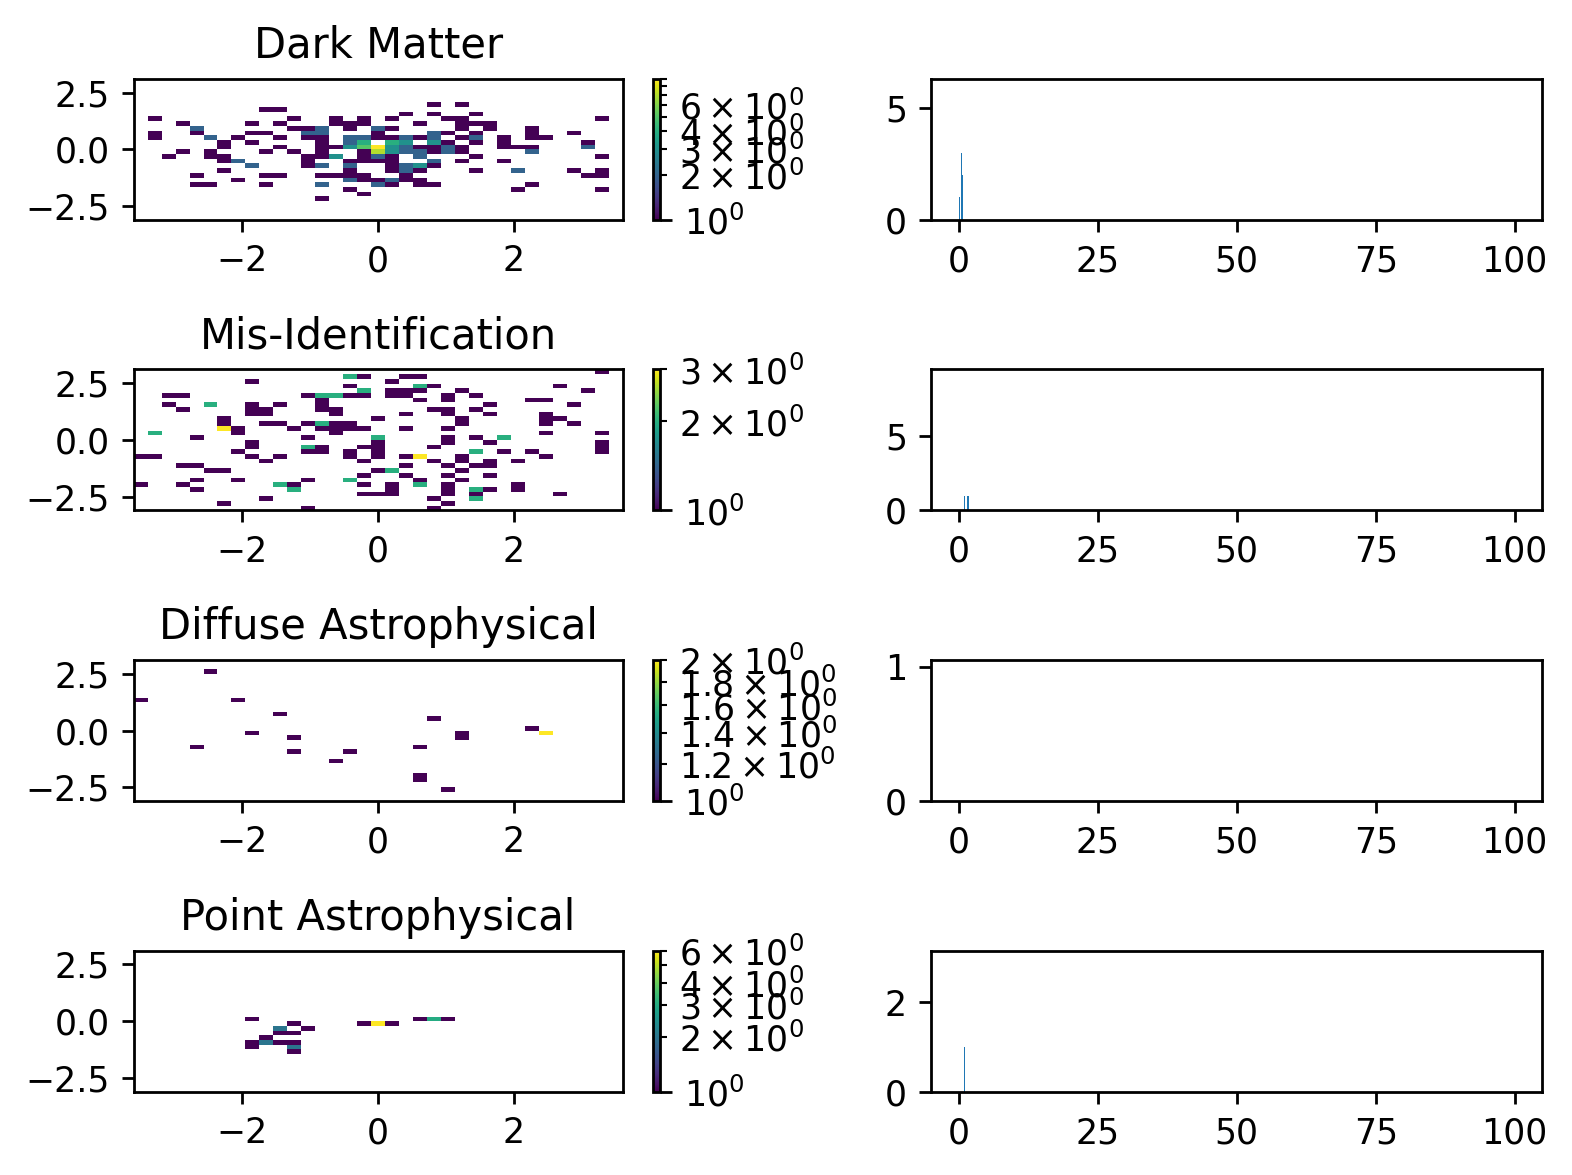

In [18]:
plt.figure(dpi=250)
plt.subplot(421)
plt.title("Dark Matter")
plt.hist2d(signal_lon_measured,signal_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)), norm=LogNorm())
plt.colorbar()

plt.subplot(422)
plt.hist(signal_energy_measured, bins=bin_centres_to_edges(energy_recon_axis))


plt.subplot(423)
plt.title("Mis-Identification")

plt.hist2d(ccr_lon_measured, ccr_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)), norm=LogNorm())
plt.colorbar()


plt.subplot(424)
plt.hist(ccr_energy_measured, bins=bin_centres_to_edges(energy_recon_axis))


plt.subplot(425)
plt.title("Diffuse Astrophysical")
plt.hist2d(diffuse_astro_lon_measured,diffuse_astro_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)), norm=LogNorm())
plt.colorbar()

plt.subplot(426)
plt.hist(diffuse_astro_energy_measured, bins=bin_centres_to_edges(energy_recon_axis))

plt.subplot(427)
plt.title("Point Astrophysical")
plt.hist2d(point_astro_lon_measured,point_astro_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)), norm=LogNorm())
plt.colorbar()

plt.subplot(428)
plt.hist(point_astro_energy_measured, bins=bin_centres_to_edges(energy_recon_axis))




plt.tight_layout()
plt.show()

## Final simulation output

In [19]:
measured_energy = list(signal_energy_measured)+list(diffuse_astro_energy_measured)+list(point_astro_energy_measured)+list(ccr_energy_measured)
measured_lon = list(signal_lon_measured)+list(diffuse_astro_lon_measured)+list(point_astro_lon_measured)+list(ccr_lon_measured)
measured_lat = list(signal_lat_measured)+list(diffuse_astro_lat_measured)+list(point_astro_lat_measured)+list(ccr_lat_measured)

# <h1><b>Analysis

## Marginalisation

In [20]:
nbins_logmass = 101

if nsig is None:
    nsig = len(list(measured_energy))

logmasswindowwidth      = 7/np.sqrt(nsig)

logmasslowerbound       = np.log10(truemass)-logmasswindowwidth
logmassupperbound       = np.log10(truemass)+logmasswindowwidth

# if 1:
if logmasslowerbound<np.log10(energy_recon_axis)[0]:
    logmasslowerbound = np.log10(energy_recon_axis)[0]
# if 1:
if logmassupperbound>2:
    logmassupperbound = 2


massrange            = np.logspace(logmasslowerbound, logmassupperbound, nbins_logmass) 

In [21]:
hyperparameter_likelihood_instance = discrete_hyperparameter_likelihood(priors=(DM_prior, ccr_bkg_prior, diffuse_astro_bkg_prior, point_astro_bkg_prior), likelihood=single_loglikelihood, 
                                                               dependent_axes=(energy_true_axis,  longitudeaxistrue, latitudeaxistrue), dependent_logjacob=true_logjacob,
                                                               hyperparameter_axes = ((massrange,), (None,), (None,), (None, )), 
                                                               numcores=numcores, likelihoodnormalisation = log_psf_normalisations+log_edisp_normalisations)

measured_energy = [float(measured_energy_val) for measured_energy_val in measured_energy]
margresults = hyperparameter_likelihood_instance.nuisance_log_marginalisation(axisvals= (measured_energy, measured_lon, measured_lat))

Setting up prior matrices: 100%|██████████| 4/4 [01:13<00:00, 18.30s/it]
Performing parallelized direct event marginalisation: 100%|██████████| 500/500 [00:00<00:00, 602456.77it/s]
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/likelihoods/irfs/gammapy_wrappers.py:115: RuntimeWarning: divide by zero encountered in log
  output  = np.log(psffull.evaluate(energy_true=true_energy*u.TeV,
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/likelihoods/irfs/gammapy_wrappers.py:119: RuntimeWarning: divide by zero encountered in log
  output  += np.log(edispfull.evaluate(energy_true=true_energy*u.TeV,
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/integration.py:140: RuntimeWarning: divide by zero encountered in log
  result= np.logaddexp(result, np.log(addon)-max_val)
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/integration.py:138: RuntimeWarning

In [22]:
margresultsarray = np.array(margresults)
sigmargresults = np.squeeze(np.vstack(margresultsarray[:,0])).T
ccrmargresults = np.squeeze(np.vstack(margresultsarray[:,1]))
diffuse_astromargresults = np.squeeze(np.vstack(margresultsarray[:,2]))
point_astromargresults = np.squeeze(np.vstack(margresultsarray[:,3]))

margresultsarray[0:10].shape

(10, 4)

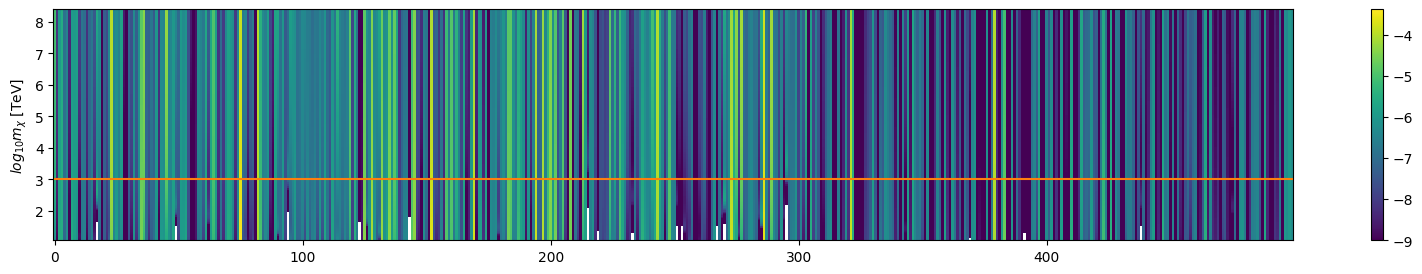

In [23]:
fig, ax = plt.subplots(figsize=(20,3))
plt.pcolormesh(*np.meshgrid(list(range(NumEvents)), massrange, indexing='ij'), 
               sigmargresults.T-special.logsumexp(sigmargresults, axis=1), 
               cmap='viridis', vmin=-9)
plt.ylabel(r'$log_{10}m_\chi$ [TeV]')
plt.axhline(truemass, c='tab:orange')
plt.colorbar()
plt.show()

## Calculating posterior

In [24]:
nbins_sigfrac               = 51
sigfrac_windowwidth         = 10/np.sqrt(NumEvents)
ccrfrac_windowwidth         = 8/np.sqrt(NumEvents)
diffusefrac_windowwidth     = 20/np.sqrt(NumEvents)

nbins_ccr_frac              = 51
nbins_diffuse_frac          = 51

sigfrac_range_upperbound = sigfraction+sigfrac_windowwidth
sigfrac_range_lowerbound = sigfraction-sigfrac_windowwidth



if sigfrac_range_upperbound>1:
    sigfrac_range_upperbound = 1
if sigfrac_range_lowerbound<0:
    sigfrac_range_lowerbound = 0

ccrfrac_of_bkg_range_upperbound = ccr_of_bkg_fraction+ccrfrac_windowwidth
ccrfrac_of_bkg_range_lowerbound = ccr_of_bkg_fraction-ccrfrac_windowwidth

if ccrfrac_of_bkg_range_upperbound>1:
    ccrfrac_of_bkg_range_upperbound = 1
if ccrfrac_of_bkg_range_lowerbound<0:
    ccrfrac_of_bkg_range_lowerbound = 0

diffusefrac_of_astro_range_upperbound = diffuse_of_astro_fraction+diffusefrac_windowwidth
diffusefrac_of_astro_range_lowerbound = diffuse_of_astro_fraction-diffusefrac_windowwidth


if diffusefrac_of_astro_range_upperbound>1:
    diffusefrac_of_astro_range_upperbound = 1
if diffusefrac_of_astro_range_lowerbound<0:
    diffusefrac_of_astro_range_lowerbound = 0


sigfracrange = np.linspace(sigfrac_range_lowerbound,    sigfrac_range_upperbound,   nbins_sigfrac)
ccrfrac_of_bkg_range = np.linspace(ccrfrac_of_bkg_range_lowerbound,ccrfrac_of_bkg_range_upperbound , nbins_ccr_frac)
diffuse_of_astro_range = np.linspace(diffusefrac_of_astro_range_lowerbound,diffusefrac_of_astro_range_upperbound, nbins_diffuse_frac)


skipfactor = 10
mixtureaxes = sigfracrange, ccrfrac_of_bkg_range, diffuse_of_astro_range
new_log_posterior = 0
loopstart = time.perf_counter()
for dataidx in tqdm(range(int(round(margresultsarray.shape[0]/skipfactor)))):
    tempmargresultsarray = margresultsarray[dataidx*skipfactor:dataidx*skipfactor+skipfactor]
    new_log_posterior += hyperparameter_likelihood_instance.create_discrete_mixture_log_hyper_likelihood(
        mixture_axes=(*mixtureaxes,), log_margresults=tempmargresultsarray)

    

new_log_posterior = new_log_posterior - special.logsumexp(new_log_posterior)

endertimer = time.perf_counter()


100%|██████████| 50/50 [09:11<00:00, 11.03s/it]


In [25]:
log_posterior = np.squeeze(new_log_posterior)

In [26]:
help(logdensity_matrix_plot)

Help on function logdensity_matrix_plot in module gammabayes.utils.plotting:

logdensity_matrix_plot(axes, log_dist_matrix, truevals=None, sigmalines_1d=True, sigmas=range(0, 6), cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x153f4e3c0>, contours2d=False, levels=array([0.99999627, 0.99966454, 0.988891  , 0.86466472, 0.39346934]), axis_names=None, suptitle='', suptitlesize=12, plot_density=False, norm=None, single_dim_yscales='symlog', single_dim_ylabel='', vmin=None, vmax=None, **kwargs)



(51,) (51,)
(51,) (51,)
(51,) (51,)
(101,) (101,)


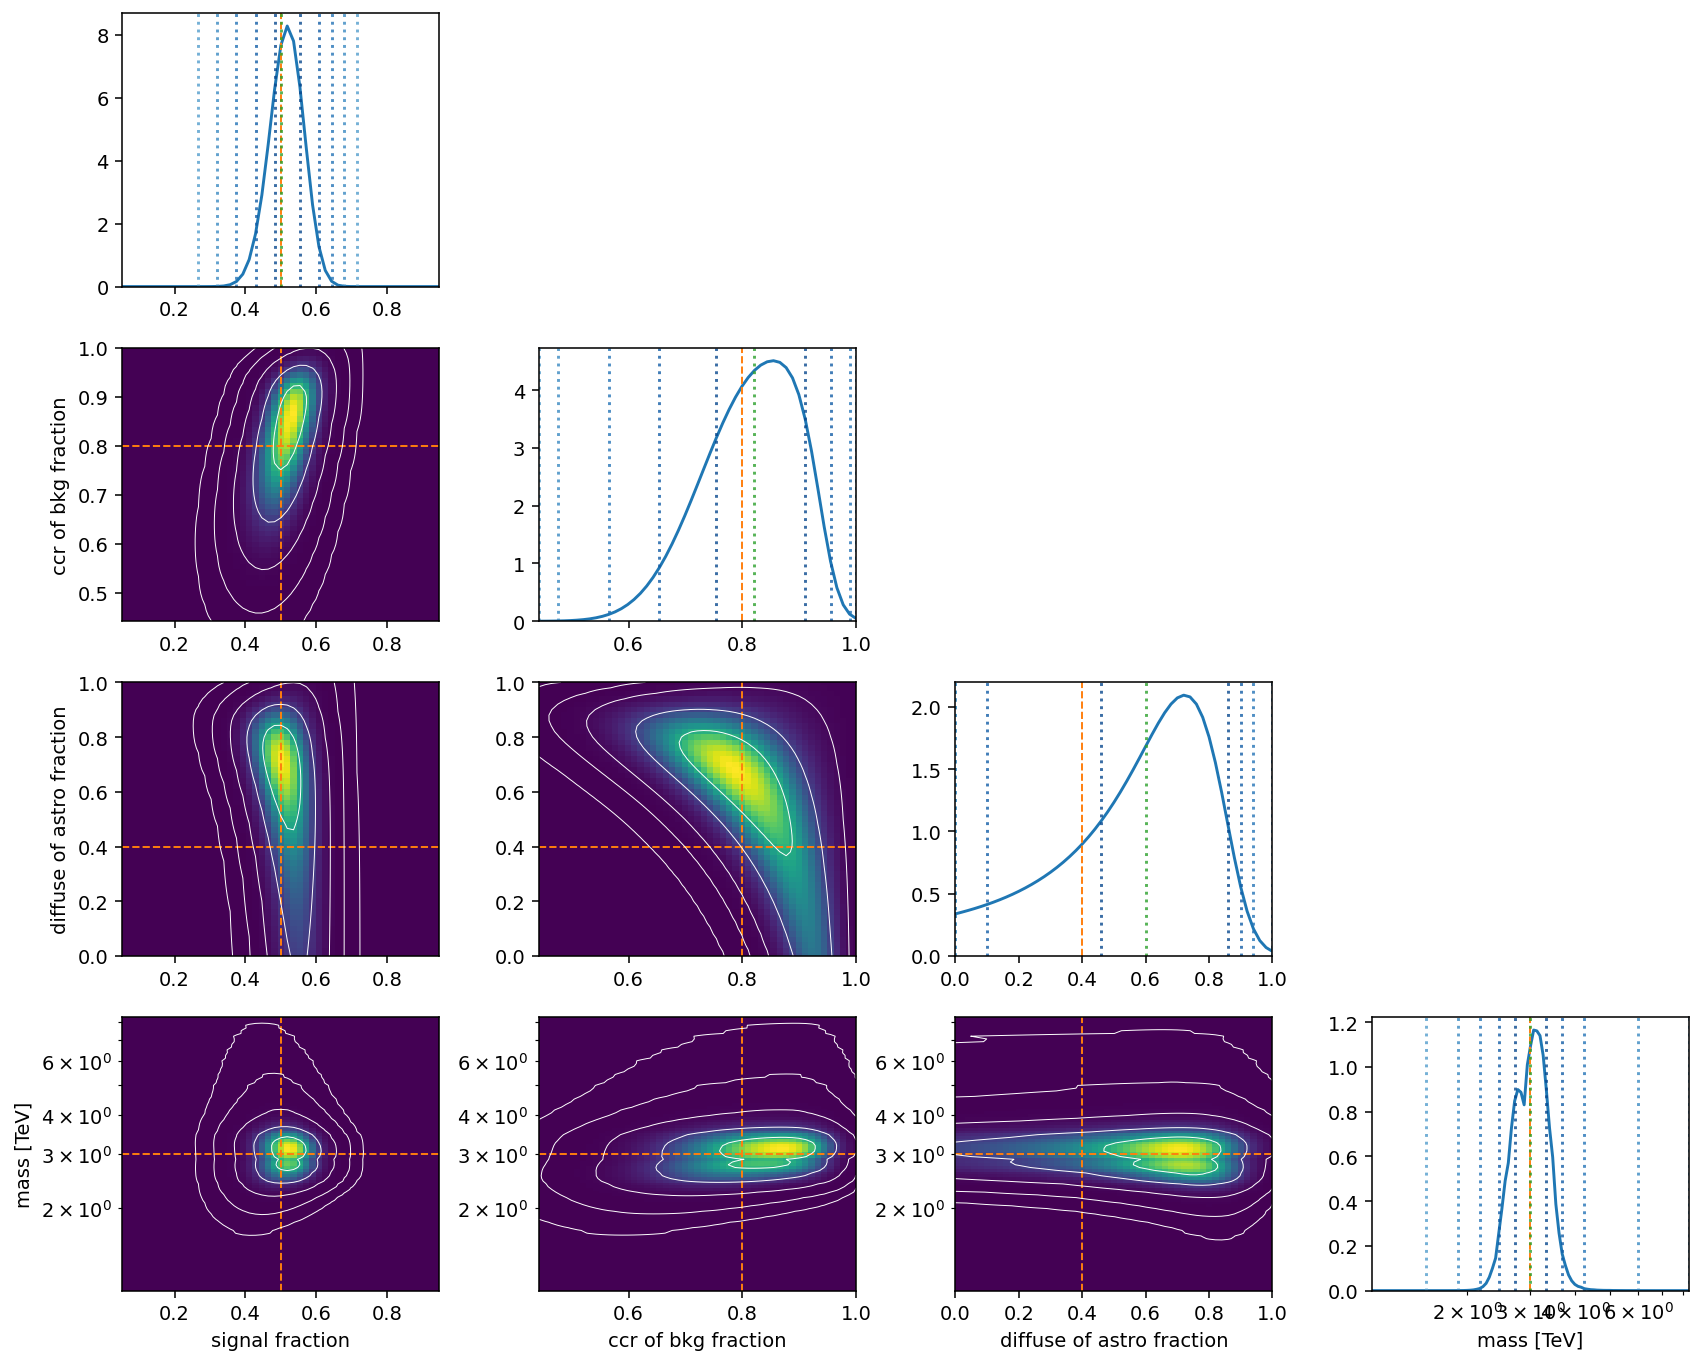

In [27]:
from gammabayes.utils.plotting import logdensity_matrix_plot
from scipy.stats import norm as norm1d
fig, ax = logdensity_matrix_plot(axes=(*mixtureaxes, massrange,), log_dist_matrix=log_posterior-special.logsumexp(log_posterior), 
                       truevals=(sigfraction, ccr_of_bkg_fraction, diffuse_of_astro_fraction, truemass,), contours2d=True, plot_density=True,
                       axis_names=('signal fraction', 'ccr of bkg fraction', 'diffuse of astro fraction', r'mass [TeV]', ),
                       dpi=140, figsize=(12,10), single_dim_yscales='linear')

[ax.set_yscale('log') for ax in ax[-1,:][:-1]];
ax[-1,-1].set_xscale('log')
plt.show()

In [28]:
discrete_hyperparameter_continuous_mix_sampler_instance = discrete_hyperparameter_continuous_mix_post_process_sampler(
    hyper_param_ranges_tuple=((massrange,), (None,), (None,), (None,),), mixture_axes=mixtureaxes,
    margresultsarray  = margresultsarray,
    nestedsampler_kwarg_dict ={'nlive':500}
    )

In [29]:
posterior_results = discrete_hyperparameter_continuous_mix_sampler_instance.generate_log_hyperlike(
    run_nested_kwarg_dict = {'dlogz':0.5},
    )

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/samplers/dynesty/discrete_continuous_mix_samplers.py:88: UserWarning: Calculating hyper log-likelihood with multiprocessing.
  warnings.warn("Calculating hyper log-likelihood with multiprocessing.")
3751it [05:03, 12.36it/s, +500 | bound: 9 | nc: 1 | ncall: 24376 | eff(%): 17.804 | loglstar:   -inf < -1986.470 <    inf | logz: -1993.217 +/-  0.112 | dlogz:  0.001 >  0.500]


In [30]:
posterior_results_equal = posterior_results.samples_equal()

[(0.18054698609618275, 1), (0.2353082515026514, 1), (0, 1), (0.021896440847613663, 1)]


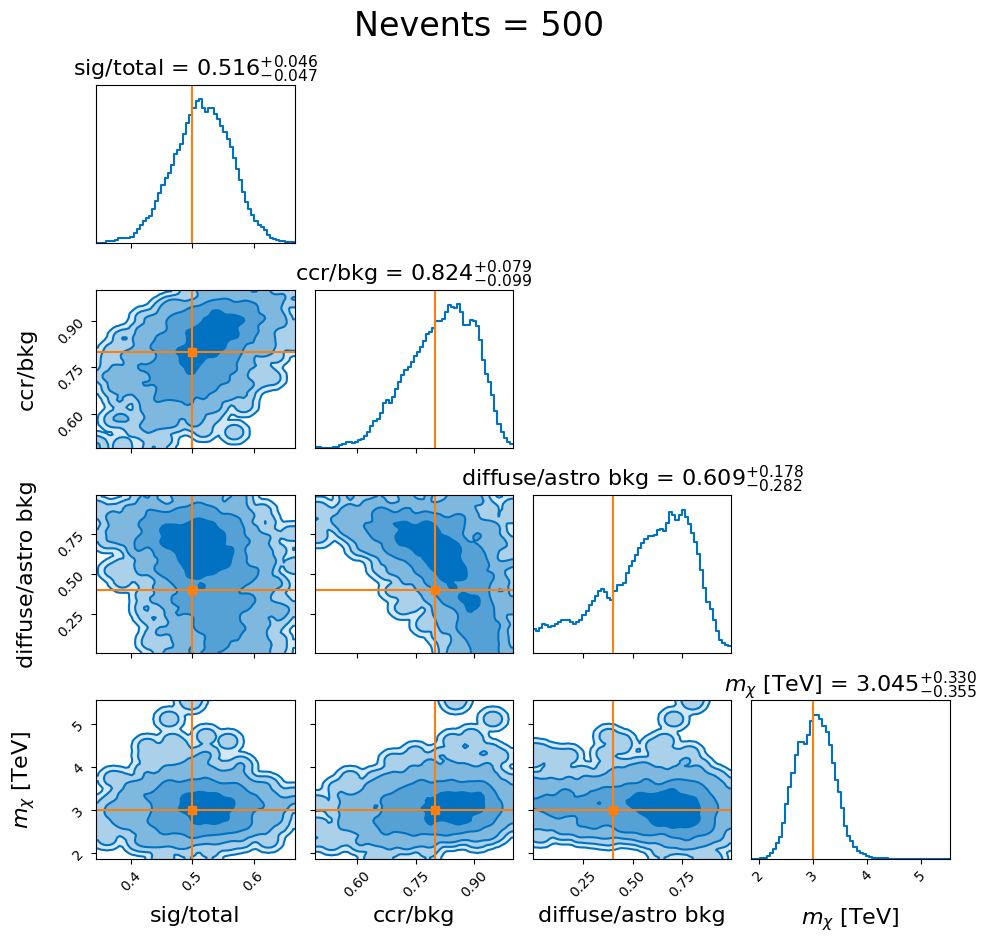

In [31]:
from corner import corner

def title_format_func(title, value, uncertainty, fmt='.2e'):
    exponent = int(fmt[-1])  # Extract the exponent from the format string
    formatted_value = format(value, fmt)
    formatted_uncertainty = format(uncertainty, fmt)
    return f'{title} = ({formatted_value} +/- {formatted_uncertainty}) * 10^{exponent}'


defaults_kwargs = dict(
    bins=64,
    smooth=1.5, 
    smooth1d=1.0,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16), title_fmt='.3f', color='#0072C1',
    truth_color='tab:orange', 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.), 1 - np.exp(-8), 1 - np.exp(-25/2)),
    plot_datapoints=True, 
    fill_contours=True,
    max_n_ticks=4, 
    # hist_kwargs=dict(density=True),
    )



# if True:
#     defaults_kwargs['truth_color'] = 'tab:blue'
#     defaults_kwargs['color'] = '#FF8C00'


ranges = [(min(posterior_results_equal[:, i])-0.5*np.ptp(posterior_results_equal[:, i]), 
           max(posterior_results_equal[:, i])+0.5*np.ptp(posterior_results_equal[:, i]),
           ) for i in range(posterior_results_equal.shape[1])]


for idx, range_idx in enumerate(ranges):
    if not(min(posterior_results_equal[:, idx])<0):
        if range_idx[0]<0 and range_idx[1]>1:
            ranges[idx] = (0,1)
        elif range_idx[0]<0:
            ranges[idx] = (0,range_idx[1])
        else:
            ranges[idx] = (range_idx[0], 1)



print(ranges)

fig = corner(posterior_results_equal,# range=ranges,
    labels=['sig/total', 'ccr/bkg','diffuse/astro bkg', r'$m_\chi$ [TeV]'],
     show_titles=True, truths =(sigfraction, ccr_of_bkg_fraction, diffuse_of_astro_fraction,truemass),  **defaults_kwargs)
axes = fig.axes
plt.suptitle(f"Nevents = {NumEvents}", size=24)
plt.tight_layout()
plt.show()

For this specific example this sampler was quicker than the brute force approach and this problem only becomes worse when one of the mixture is very constrained (e.g. a realistic dark matter signal fraction) and the brute force approach would need an even higher resolution to be sure it picks up the peak. With the sampling not much would change.